<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

### Tutorial For Cellular Automaton Vegetation Model Coupled With Ecohydrologic Model

<hr>
<small> For instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For the unexpanded version to download and run, click here: <a href="http://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/ecohydrology/cellular_automaton_vegetation_DEM/cellular_automaton_vegetation_DEM_unexpanded.ipynb">http://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/ecohydrology/cellular_automaton_vegetation_DEM/cellular_automaton_vegetation_DEM_unexpanded.ipynb</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

This tutorial demonstrates implementation of the Cellular Automaton Tree-GRass-Shrub Simulator (CATGRaSS) [Zhou et al., 2013] on a flat domain. This model is built using components from the Landlab component library. CATGRaSS is spatially explicit model of plant coexistence. It simulates local ecohydrologic dynamics (soil moisture, transpiration, biomass) and spatial evolution of tree, grass, and shrub Plant Functional Types (PFT) driven by rainfall and solar radiation. 

Each cell in the model grid can hold a single PFT or remain empty. Tree and shrub plants disperse seeds to their neighbors. Grass seeds are assumed to be available at each cell. Establishment of plants in empty cells is determined probabilistically based on water stress of each PFT. Plants with lower water stress have higher probability of establishment. Plant mortality is simulated probabilistically as a result of aging and drought stress. Fires and grazing will be added to this model soon.  

This model (driver) contains:
  - A local vegetation dynamics model that simulates storm and inter-storm water balance and ecohydrologic fluxes (ET, runoff), and plant biomass dynamics by coupling the following components:
        - PrecipitationDistribution
        - Radiation
        - PotentialEvapotranspiration
        - SoilMoisture
        - Vegetation

  - A spatially explicit probabilistic cellular automaton component that simulates plant competition by tracking establishment and mortality of plants based on soil moisture stress:
        - VegCA
    
To run this Jupyter notebook, please make sure that the following files are in the same folder:
        - cellular_automaton_vegetation_flat_domain.ipynb (this notebook)
        - Inputs_Vegetation_CA.txt (Input parameters for the model)
        - Ecohyd_functions_flat.py (Utility functions)

[Ref: Zhou, X, E. Istanbulluoglu, and E.R. Vivoni. "Modeling the ecohydrological role of aspect-controlled radiation on tree-grass-shrub coexistence in a semiarid climate." Water Resources Research 49.5 (2013): 2872-2895]


In this tutorial, we are going to work with a landscape in central New Mexico, USA, where aspect controls the organization of PFTs. The climate in this area is semi-arid with Mean Annual Precipitation (MAP) of 254 mm [Zhou et. al 2013]. 
We will do the following: 
- Import a landscape 
- Initialize the landscape with random distribution of PFTs
- Run the coupled Ecohydrology and cellular automata plant competition model for 50 years
- Visualize and examine outputs

#### Let us walk through the code:

Import the required libraries

In [ ]:
from __future__ import print_function
%matplotlib inline

In [1]:
import time
import numpy as np
from landlab import RasterModelGrid as rmg
from landlab import load_params
from Ecohyd_functions_flat import (Initialize_, Empty_arrays,
                                   Create_PET_lookup, Save_, Plot_)

C:\Users\saisiddu\Anaconda2\lib\site-packages\matplotlib\__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Note: 'Ecohyd_functions_flat.py' is a utility script that contains 'functions', which instantiates components and manages inputs and outputs, and help keep this driver concise. Contents of 'Ecohyd_functions_flat.py' can be a part of this driver (current file), however left out to keep driver concise.

To minimize computation time, we will use two grids in this driver. One grid will represent a flat landscape or domain (i.e., landscape with same elevation), on which the cellular automata plant competition will be simulated at an yearly time step. Another grid, with enough cells to house one cell for each of the plant functional types (PFTs), will be used to simulate soil moisture decay and local vegetation dynamics, in between successive storms (i.e. time step = one storm). Cumulative water stress (stress experienced by plants due to lack of enough soil moisture) will be calculated over an year and mapped to the other grid.

- grid: This grid represents the actual landscape. Each cell can be occupied by a single PFT such as tree, shrub, grass, or can be empty (bare). Initial PFT distribution is randomnly generated from inputs of percentage of cells occupied by each PFT.

- grid1: This grid allows us to calculate PFT specific cumulative water stress (cumulated over each storm in the year) and mapped with 'grid'.

Note: In this tutorial, the physical ecohydrological components and cellular automata plant competition will be run on grids with different resolution. To use grids with same resolution, see the tutorial 'cellular_automaton_vegetation_DEM.ipynb'.

In [2]:
grid1 = rmg((100, 100), spacing=(5., 5.))
grid = rmg((5, 4), spacing=(5., 5.))

Include the input file that contains all input parameters needed for all components. This file can either be a python dictionary or a text file that can be converted into a python dictionary. If a text file is provided, it will be converted to a Python dictionary. Here we use an existing text file prepared for this exercise.

In [3]:
InputFile = 'Inputs_Vegetation_CA_flat.txt'
data = load_params(InputFile)  # Create dictionary that holds the inputs

Instantiate landlab components to simulate corresponding attributes. In this example, we shall demonstrate the use of seasonal rainfall and PFT-specific potential evapotranspiration. The instantiated objects are:
- PD_D: object for dry season rainfall, 
- PD_W: object for wet season rainfall, 
- Rad: Radiation object computes radiation factor defined as the ratio of total shortwave radiation incident on a sloped surface to total shortwave radiation incident on a flat surface. Note: in this example a flat domain is considered. Radiation factor returned will be a cellular field of ones. This component is included because potential evaporanspiration (PET) component receives an input of radiation factor as a field.
- PET_PFT: Plant specific PET objects. PET is upper boundary to ET. For long-term simulations PET is represented using a cosine function as a function of day of year. Parameters of this function were obtained from P-M model application at a weather station. PET is spatially distributed by using the radiation factor.
- SM: Soil Moisture object simulates depth-averaged soil moisture at each cell using inputs of potential evapotranspiration, live leaf area index and vegetation cover.
- VEG: Vegetation dynamics object simulates net primary productivity, biomass and leaf area index (LAI) at each cell based on inputs of root-zone average soil moisture.
- vegca: Cellular Automaton plant competition object is run once every year. This object is initialized with a random cellular field of PFT. Every year, this object updates the cellular field of PFT based on probabilistic establishment and mortality of PFT at each cell.

Note: Almost every component in landlab is coded as a 'class' (to harness the advantages of objective oriented programming). An 'object' is the instantiation of the 'class' (for more information, please refer any objective oriented programming book). A 'field' refers to a Landlab field (please refer to the [Landlab documentation](https://github.com/landlab/landlab/wiki/Grid#adding-data-to-a-landlab-grid-element-using-fields) to learn more about Landlab fields).

Now let's instantiate all Landlab components that we are going to use for this tutorial:

In [4]:
PD_D, PD_W, Rad, PET_Tree, PET_Shrub, PET_Grass, SM, VEG, vegca = Initialize_(
            data, grid, grid1)

Lets look at the initial organization of PFTs

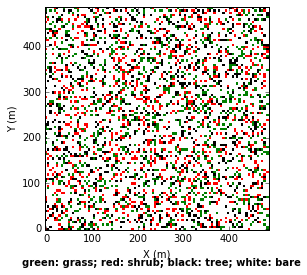

In [5]:
import matplotlib.pyplot as plt
from landlab.plot import imshow_grid
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(
            ['green', 'red', 'black', 'white', 'red', 'black'])
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
description = 'green: grass; red: shrub; black: tree; white: bare'
plt.figure(101)
imshow_grid(grid1, 'vegetation__plant_functional_type', values_at='cell', cmap=cmap,
            grid_units=('m', 'm'), norm=norm, limits=[0, 5],
            allow_colorbar=False)
plt.figtext(0.2, 0.0, description,
            weight='bold', fontsize=10)

Specify an approximate number of years for the model to run. For this example, we will run the simulation for 600 years. It might take less than 2+ minutes to run.

In [6]:
n_years = 600      # Approx number of years for model to run
# Calculate approximate number of storms per year
fraction_wet = (data['doy__end_of_monsoon']-data['doy__start_of_monsoon'])/365.
fraction_dry = 1 - fraction_wet
no_of_storms_wet = (8760 * (fraction_wet)/(data['mean_interstorm_wet'] +
                    data['mean_storm_wet']))
no_of_storms_dry = (8760 * (fraction_dry)/(data['mean_interstorm_dry'] +
                    data['mean_storm_dry']))
n = int(n_years * (no_of_storms_wet + no_of_storms_dry))

Create empty arrays to store spatio-temporal data over multiple iterations. The captured data can be used for plotting model outputs.

In [7]:
P, Tb, Tr, Time, VegType, PET_, Rad_Factor, EP30, PET_threshold = Empty_arrays(
                n, grid, grid1)

To reduce computational overhead, we shall create a lookup array for plant-specific PET values for each day of the year.

In [8]:
Create_PET_lookup(Rad, PET_Tree, PET_Shrub, PET_Grass,  PET_, Rad_Factor,
                  EP30, grid)

Specify current_time (in years). current_time is the current time in the simulation.

In [9]:
# # Represent current time in years
current_time = 0            # Start from first day of Jan

# Keep track of run time for simulation - optional
Start_time = time.clock()     # Recording time taken for simulation

# declaring few variables that will be used in the storm loop
time_check = 0.     # Buffer to store current_time at previous storm
yrs = 0             # Keep track of number of years passed
WS = 0.             # Buffer for Water Stress
Tg = 270        # Growing season in days

The loop below couples the components introduced above in a for loop until all "n" number of storms are generated. Time is advanced by the soil moisture object based on storm and interstorm durations that are estimated by the strom generator object. The ecohydrologic model is run each storm whereas cellular automaton vegetation component is run once every year.

Note: This loop might take less than 2 minutes (depending on your computer) to run for 600 year simulation. Ignore any warnings you might see.

In [10]:
# # Run storm Loop
for i in range(0, n):
    # Update objects

    # Calculate Day of Year (DOY)
    Julian = np.int(np.floor((current_time - np.floor(current_time)) * 365.))

    # Generate seasonal storms
    # for Dry season
    if Julian < data['doy__start_of_monsoon'] or Julian > data[
                        'doy__end_of_monsoon']:
        PD_D.update()
        P[i] = PD_D.storm_depth
        Tr[i] = PD_D.storm_duration
        Tb[i] = PD_D.interstorm_duration
    # Wet Season - Jul to Sep - NA Monsoon
    else:
        PD_W.update()
        P[i] = PD_W.storm_depth
        Tr[i] = PD_W.storm_duration
        Tb[i] = PD_W.interstorm_duration

    # Spatially distribute PET and its 30-day-mean (analogous to degree day)
    grid['cell']['surface__potential_evapotranspiration_rate'] = PET_[Julian]
    grid['cell']['surface__potential_evapotranspiration_30day_mean'] = EP30[
                Julian]

    # Assign spatial rainfall data
    grid['cell']['rainfall__daily_depth'] = P[i] * np.ones(grid.number_of_cells)

    # Update soil moisture component
    current_time = SM.update(current_time, Tr=Tr[i], Tb=Tb[i])

    # Decide whether its growing season or not
    if Julian != 364:
        if EP30[Julian+1, 0] > EP30[Julian, 0]:
            PET_threshold = 1
            # 1 corresponds to ETThresholdup (begin growing season)
        else:
            PET_threshold = 0
            # 0 corresponds to ETThresholddown (end growing season)

    # Update vegetation component
    VEG.update(PETThreshold_switch=PET_threshold, Tb=Tb[i], Tr=Tr[i])

    # Update yearly cumulative water stress data
    WS += (grid['cell']['vegetation__water_stress'])*Tb[i]/24.

    # Record time (optional)
    Time[i] = current_time

    # Update spatial PFTs with Cellular Automata rules
    if (current_time - time_check) >= 1.:
        if yrs % 100 == 0:
            print('Elapsed time = {time} years'.format(time=yrs))
        VegType[yrs] = grid1['cell']['vegetation__plant_functional_type']
        WS_ = np.choose(VegType[yrs], WS)
        grid1['cell']['vegetation__cumulative_water_stress'] = WS_/Tg
        vegca.update()
        time_check = current_time
        WS = 0
        yrs += 1

VegType[yrs] = grid1['cell']['vegetation__plant_functional_type']

Elapsed time =  0  years


c:\users\saisiddu\documents\github\landlab\landlab\components\plant_competition_ca\plant_competition_ca.py:299: RuntimeWarning: divide by zero encountered in divide
  Peg = np.amin(np.vstack((Phi_g/(n*self._INg), Pemaxg)), axis=0)


Elapsed time =  100  years
Elapsed time =  200  years
Elapsed time =  300  years
Elapsed time =  400  years
Elapsed time =  500  years


Time_Consumed is an optional variable that gives information about computer running time

In [11]:
Final_time = time.clock()
Time_Consumed = (Final_time - Start_time)/60.    # in minutes
print('Time_consumed = {time} minutes'.format(time=Time_Consumed))

Time_consumed =  0.950478328277  minutes


Save the outputs using ``numpy.save()``. These files have '.nc' extension, which can be loaded using ``numpy.load()``.

In [12]:
# # Saving
sim = 'Sim_26Jul16_'
#Save_(sim, Tb, Tr, P, VegType, yrs, Time_Consumed, Time)

Let's look at outputs.

Plots of the cellular field of PFT at specified year step can be found below where:

GRASS = green;  SHRUB = red;  TREE = black;  BARE = white;  

At the end, percentage cover of each PFT is plotted with respect to time.

Plotting cellular field of Plant Functional Type
Green - Grass; Red - Shrubs; Black - Trees; White - Bare


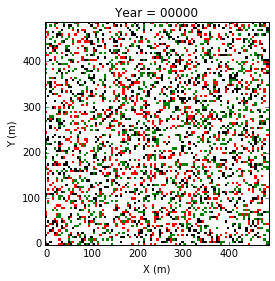

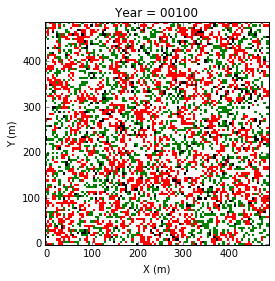

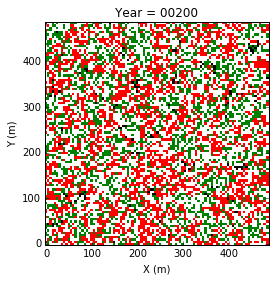

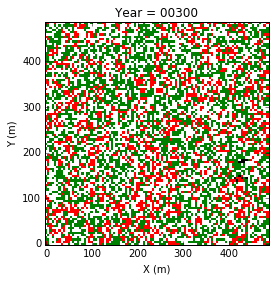

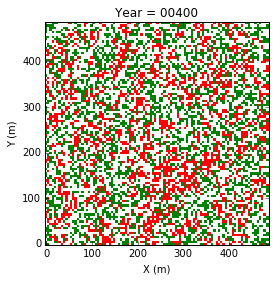

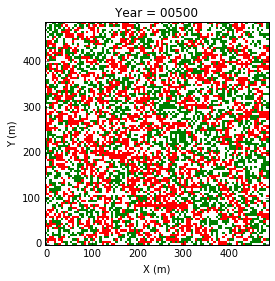

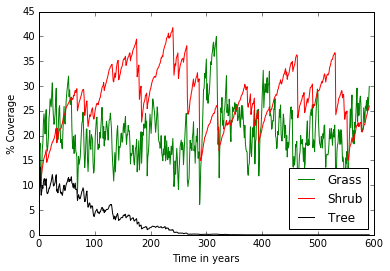

In [13]:
Plot_(grid1, VegType, yrs, yr_step=100)

If you want to explore this model further, open 'Inputs_Vegetation_CA.txt' and change the input parameters (e.g., initial PFT distribution percentages, storm characteristics, etc..).

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>